## Sentiment Analysis in Python

In this notebook we will be doing some sentiment analysis in python using two different techniques:

1. VADER (Valence Aware Dictionary and Sentiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface 
3. Huggingface Pipeline

Closely follows [Rob Mulla's](https://www.youtube.com/watch?v=QpzMWQvxXWk) youtube video.

## Step 0. Load Dataset

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.style.use('ggplot')

import nltk

In [96]:
datasetPath = "/kaggle/input/amazon-fine-food-reviews/Reviews.csv"
df = pd.read_csv(datasetPath)
df = df.head(500)

In [97]:
print(df.shape)
df.head()

(500, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Quick EDA

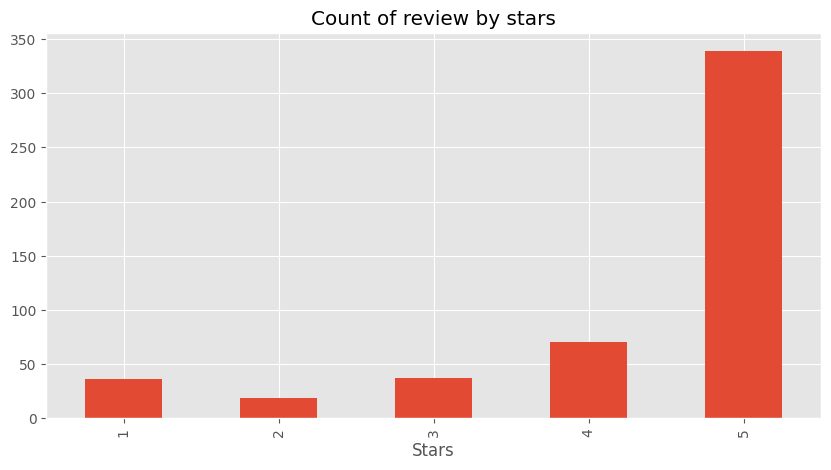

In [98]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of review by stars',
          figsize=(10,5))
ax.set_xlabel('Stars')
plt.show()
# A lot more 5 stars compared to others

### Basic NLTK

In [99]:
reviews = df['Text']
text = reviews[10]
text

"I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!"

In [100]:
tokens = nltk.word_tokenize(text)
tokens = tokens[:10]
tokens

['I', 'do', "n't", 'know', 'if', 'it', "'s", 'the', 'cactus', 'or']

In [101]:
tagged = nltk.pos_tag(tokens)
tagged

[('I', 'PRP'),
 ('do', 'VBP'),
 ("n't", 'RB'),
 ('know', 'VB'),
 ('if', 'IN'),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('the', 'DT'),
 ('cactus', 'NN'),
 ('or', 'CC')]

In [102]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  I/PRP
  do/VBP
  n't/RB
  know/VB
  if/IN
  it/PRP
  's/VBZ
  the/DT
  cactus/NN
  or/CC)


## Step 1. VADER Seniment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [103]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [104]:
sia.polarity_scores("This is very nice dish!") # lies in [-1,1], higher meaning positive

{'neg': 0.0, 'neu': 0.542, 'pos': 0.458, 'compound': 0.5244}

In [105]:
sia.polarity_scores(text) # predicts quite positive which is the case

{'neg': 0.017, 'neu': 0.846, 'pos': 0.137, 'compound': 0.9746}

In [106]:
# Computing polarity scores on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [107]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id',
                                              'neg': 'VaderNeg',
                                              'neu': 'VaderNeu',
                                              'pos': 'VaderPos',
                                              'compound': 'VaderCompound'})
vaders = vaders.merge(df, how='left')
vaders.head()

,Id,VaderNeg,VaderNeu,VaderPos,VaderCompound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot Vader result

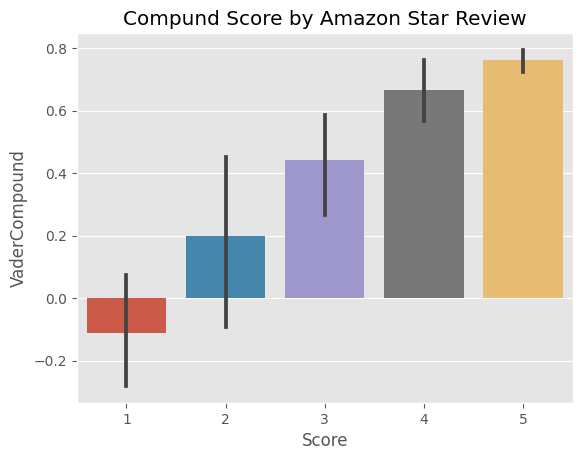

In [108]:
ax = sns.barplot(data=vaders, x='Score', y='VaderCompound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

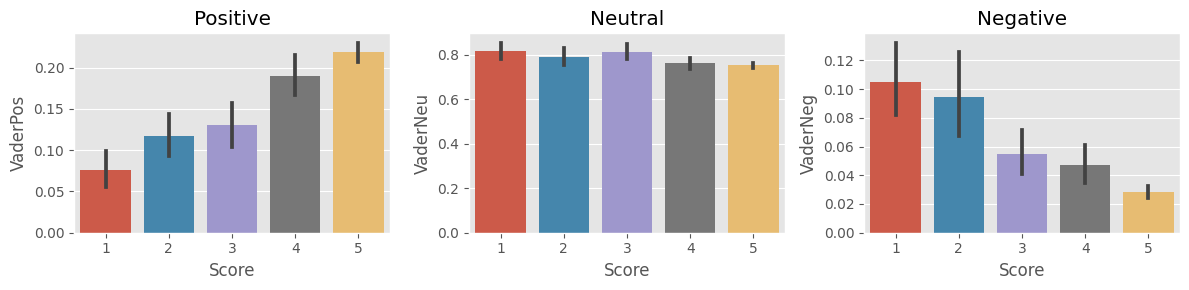

In [109]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='VaderPos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='VaderNeu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='VaderNeg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [110]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [111]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [112]:
# VADER results on text
print(text)
sia.polarity_scores(text)

I don't write very many reviews but I have to say that Kettle Brand chips are the best I have ever tasted.  Every flavor is dynamite.  If you are feeling iffy about honey dijon, I would recommend cheddar beer, absolutely amazing.  And they're healthy!  (besides a lil fat)  I have eaten a lot of chips in my day and Kettle takes the cake.  Enjoy, and don't eat them too fast.


{'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.9811}

In [113]:
# Roberta results on text
encoded_text = tokenizer(text, return_tensors='pt')
# The ** syntax before encoded_text unpacks the contents of this dictionary into individual keyword arguments 
# when calling the model. This means that instead of passing the entire dictionary as a single argument,
# each key-value pair within the dictionary becomes a separate argument to the model's __call__ method.
scores = model(**encoded_text)
scores

SequenceClassifierOutput(loss=None, logits=tensor([[-2.2464, -0.7111,  3.7556]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [114]:
scores = scores[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'RobertaNeg' : scores[0],
    'RobertaNeu' : scores[1],
    'RobertaPos' : scores[2]
}
print(scores_dict)

{'RobertaNeg': 0.0024397594, 'RobertaNeu': 0.011327226, 'RobertaPos': 0.986233}


In [115]:
def roberta_polarity_scores(example):
    encoded_text = tokenizer(text, return_tensors='pt')
    scores = model(**encoded_text)
    scores = scores[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'RobertaNeg' : scores[0],
        'RobertaNeu' : scores[1],
        'RobertaPos' : scores[2]
    }
    return scores_dict

In [116]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        res[myid] = roberta_polarity_scores(text)
    except RuntimeError:
        print(f'Broke for id {myid}')
res

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


{1: {'RobertaNeg': 0.009624243,
  'RobertaNeu': 0.049980447,
  'RobertaPos': 0.9403953},
 2: {'RobertaNeg': 0.5089861,
  'RobertaNeu': 0.45241353,
  'RobertaPos': 0.038600374},
 3: {'RobertaNeg': 0.0032289,
  'RobertaNeu': 0.09806747,
  'RobertaPos': 0.8987037},
 4: {'RobertaNeg': 0.0022951262,
  'RobertaNeu': 0.090219185,
  'RobertaPos': 0.90748566},
 5: {'RobertaNeg': 0.0016347283,
  'RobertaNeu': 0.01030247,
  'RobertaPos': 0.98806286},
 6: {'RobertaNeg': 0.0061295927,
  'RobertaNeu': 0.021795867,
  'RobertaPos': 0.97207457},
 7: {'RobertaNeg': 0.0013047527,
  'RobertaNeu': 0.007773783,
  'RobertaPos': 0.99092144},
 8: {'RobertaNeg': 0.002029357,
  'RobertaNeu': 0.005685204,
  'RobertaPos': 0.9922854},
 9: {'RobertaNeg': 0.0038735832,
  'RobertaNeu': 0.094156384,
  'RobertaPos': 0.90197},
 10: {'RobertaNeg': 0.0031034616,
  'RobertaNeu': 0.05591222,
  'RobertaPos': 0.9409843},
 11: {'RobertaNeg': 0.0191341,
  'RobertaNeu': 0.07104441,
  'RobertaPos': 0.9098215},
 12: {'RobertaNeg': 

In [117]:
roberta = pd.DataFrame(res).T
roberta = roberta.reset_index().rename(columns={'index': 'Id'})
results_df = roberta.merge(vaders, how='left')
results_df.head()

,Id,RobertaNeg,RobertaNeu,RobertaPos,VaderNeg,VaderNeu,VaderPos,VaderCompound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.049980,0.940395,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.038600,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [118]:
results_df.columns

Index(['Id', 'RobertaNeg', 'RobertaNeu', 'RobertaPos', 'VaderNeg', 'VaderNeu',
       'VaderPos', 'VaderCompound', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text'],
      dtype='object')

## Compare both models

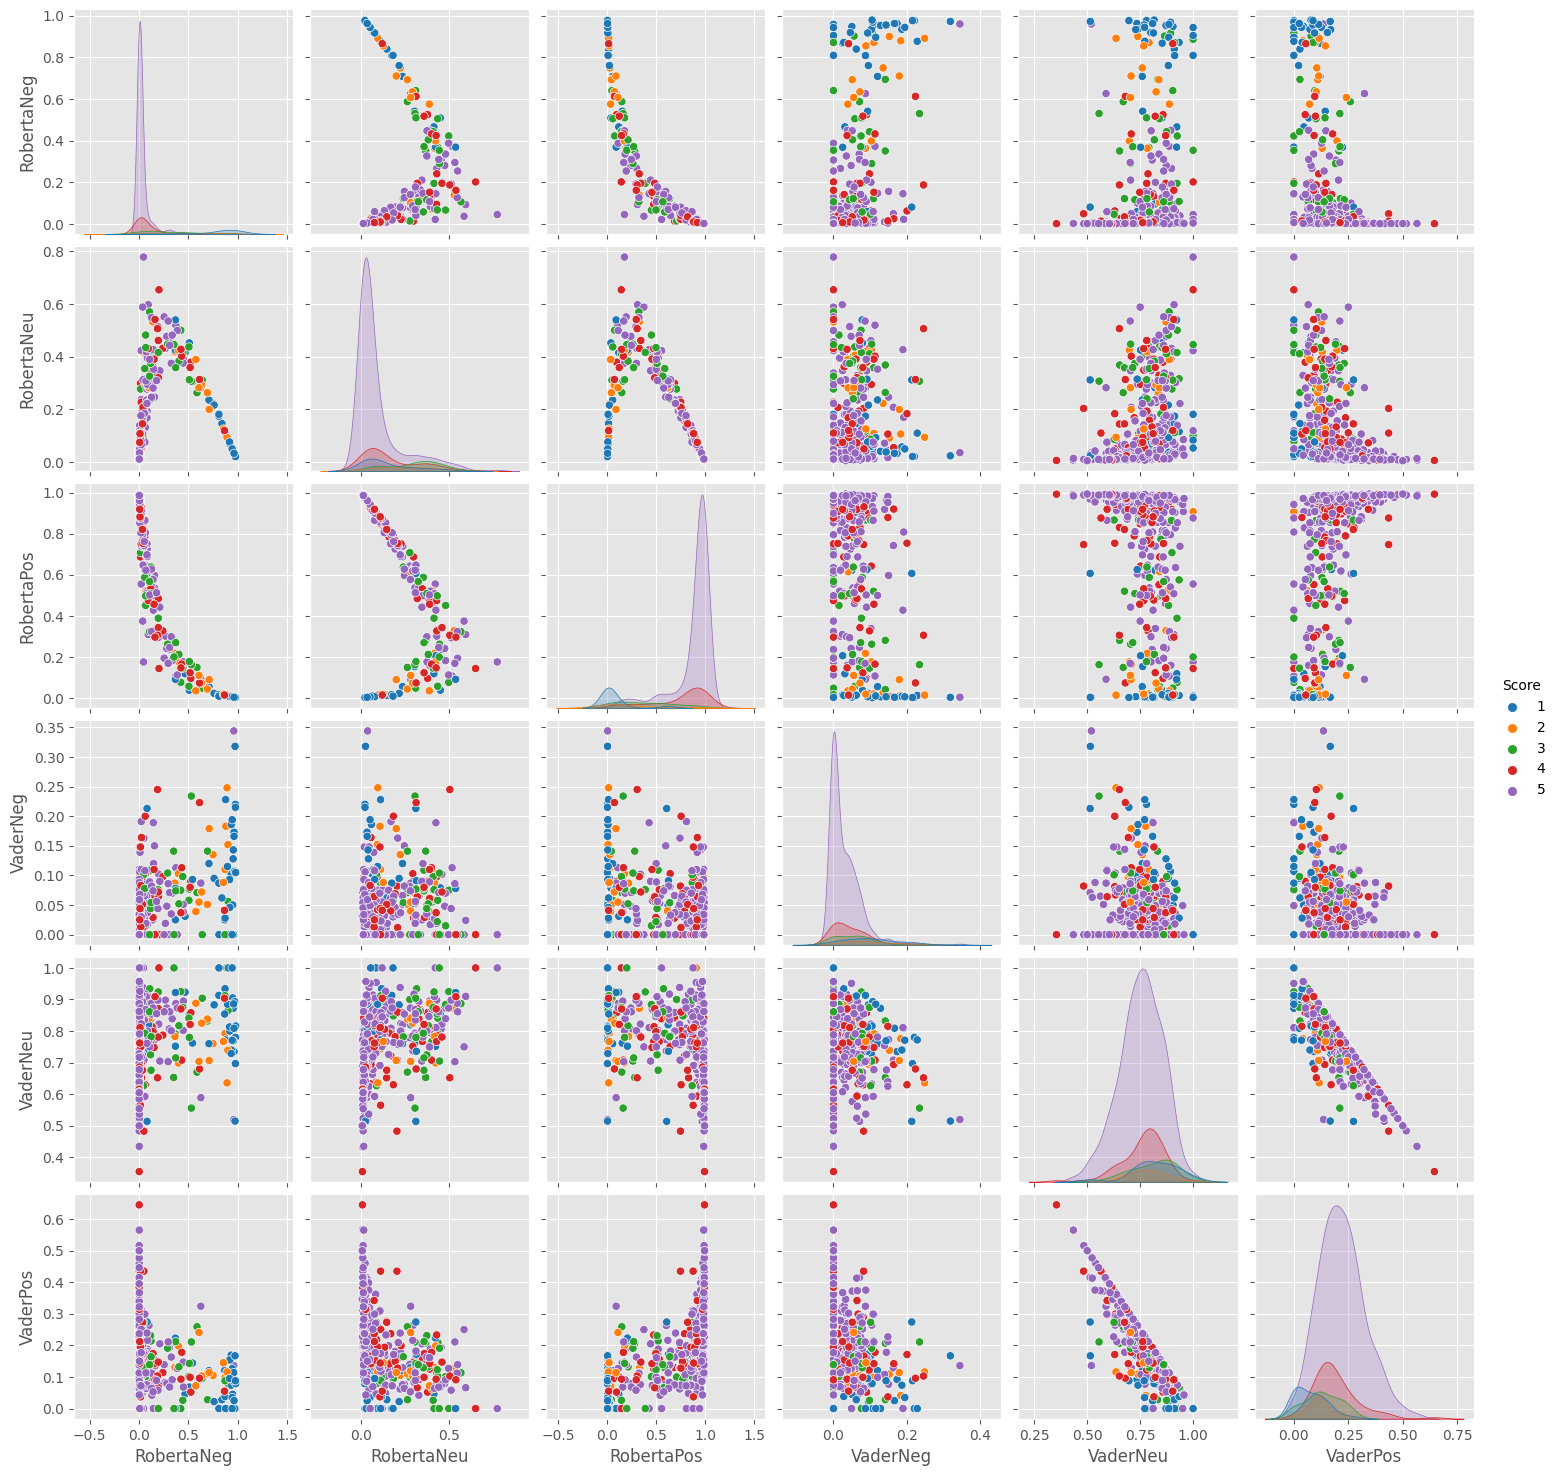

In [119]:
sns.pairplot(data=results_df,
             vars=['RobertaNeg', 'RobertaNeu', 'RobertaPos',
                   'VaderNeg', 'VaderNeu', 'VaderPos'],
             hue='Score',
             palette='tab10')

plt.show()

## Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [ ]:
results_df.query('Score == 1') \
    .sort_values('RobertaPos', ascending=False)[['Text','RobertaPos', 'RobertaNeg', 'RobertaNeu']].values[0]

In [ ]:
results_df.query('Score == 1') \
    .sort_values('VaderPos', ascending=False)[['Text','VaderPos', 'VaderNeg', 'VaderNeu', 'VaderCompound']].values[0]

In [ ]:
# negative sentiment 5-Star view
results_df.query('Score == 5') \
    .sort_values('RobertaNeg', ascending=False)[['Text','RobertaPos', 'RobertaNeg', 'RobertaNeu']].values[0]

In [ ]:
results_df.query('Score == 5') \
    .sort_values('VaderNeg', ascending=False)[['Text','VaderPos', 'VaderNeg', 'VaderNeu', 'VaderCompound']].values[0]

## Extra: The Transformers Pipeline

Quick & easy way to run sentiment predictions

In [ ]:
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")

In [ ]:
sentiment_pipeline('I love playing football.')

In [ ]:
sentiment_pipeline('I am not feeling well.')

In [ ]:
sentiment_pipeline('I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money')

In [ ]:
sentiment_pipeline('this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault') # got it wrong too?